In [ ]:
import string
from threading import local
from matplotlib import pyplot as plt
import numpy as np
import cv2
import json
import numpy as np
from tqdm import tqdm
import os
from statistics import median, mode,mean
import matplotlib.image as img
from matplotlib.ticker import PercentFormatter
from matplotlib import colors
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
import scipy.stats as sts

In [ ]:
def return_pastframe_combined(data_required ):
    df = pd.DataFrame()
    for x in range(20,len(data_required)):
        df_annotation_list=pd.json_normalize(data_required[x])
        for y in range(20):
            newcolname = ('Own_speed_tminus_'+str(20-y)+'_frame')
            df_annotation_list[newcolname] = data_required[int(y)]['OwnSpeed']
            newcolname = ('Distance_ref_tminus'+str(20-y)+'_frame')
            df_annotation_list[newcolname] = data_required[int(y)]['Distance_ref']
            # newcolname = ('StrDeg_tminus'+str(20-y)+'_frame')
            # df_annotation_list[newcolname] = data_required[int(y)]['StrDeg']
        # for y in range(20):
    
        df=pd.concat([df,df_annotation_list])
    return df

In [ ]:
annotation_path = "../train_annotations/"
dir_list = os.listdir(annotation_path)
dir_list.sort()
df = pd.DataFrame()
for inddir in tqdm(dir_list,desc='dirs'):
# if(1==1):
#     inddir="420.json"
    f = open(annotation_path+inddir)
    data = json.load(f)
    df_annotation_list=pd.json_normalize(data, record_path=['sequence'])
    # print(len(data))
    # print(len(raw_file_list))
    local_distance = return_pastframe_combined(data['sequence'])
    # print(local_distance)
    df=pd.concat([df,local_distance])

dirs: 100%|██████████| 737/737 [08:13<00:00,  1.49it/s]


In [ ]:
df

,OwnSpeed,StrDeg,inf_DP,Distance_ref,TgtSpeed_ref,TgtXPos_LeftUp,TgtYPos_LeftUp,TgtWidth,TgtHeight,Own_speed_tminus_20_frame,...,Own_speed_tminus_5_frame,Distance_ref_tminus5_frame,Own_speed_tminus_4_frame,Distance_ref_tminus4_frame,Own_speed_tminus_3_frame,Distance_ref_tminus3_frame,Own_speed_tminus_2_frame,Distance_ref_tminus2_frame,Own_speed_tminus_1_frame,Distance_ref_tminus1_frame
0,32.2,1.2,5.743652,26.11,34.83,442.0,102.0,102.0,95.0,28.7,...,31.3,25.74,31.5,25.85,31.6,25.94,31.8,25.99,32.0,26.05
0,32.4,1.2,5.743652,26.14,35.09,442.0,107.0,101.0,94.0,28.7,...,31.3,25.74,31.5,25.85,31.6,25.94,31.8,25.99,32.0,26.05
0,32.6,1.0,5.743652,26.19,35.29,441.0,110.0,102.0,94.0,28.7,...,31.3,25.74,31.5,25.85,31.6,25.94,31.8,25.99,32.0,26.05
0,32.8,-0.3,5.743652,26.22,35.48,441.0,110.0,101.0,93.0,28.7,...,31.3,25.74,31.5,25.85,31.6,25.94,31.8,25.99,32.0,26.05
0,33.0,-0.5,5.743652,26.29,35.57,442.0,107.0,101.0,93.0,28.7,...,31.3,25.74,31.5,25.85,31.6,25.94,31.8,25.99,32.0,26.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,36.0,0.3,5.739014,28.48,29.74,430.0,63.0,116.0,115.0,48.6,...,49.5,48.88,49.6,48.78,49.6,48.69,49.7,48.61,49.7,48.51
0,35.7,0.3,5.739014,28.31,29.78,430.0,63.0,116.0,116.0,48.6,...,49.5,48.88,49.6,48.78,49.6,48.69,49.7,48.61,49.7,48.51
0,35.4,0.3,5.739014,28.12,29.75,430.0,64.0,116.0,117.0,48.6,...,49.5,48.88,49.6,48.78,49.6,48.69,49.7,48.61,49.7,48.51
0,35.1,0.3,5.739014,27.95,29.64,430.0,63.0,117.0,118.0,48.6,...,49.5,48.88,49.6,48.78,49.6,48.69,49.7,48.61,49.7,48.51


In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
Y=df['TgtSpeed_ref']
X=df.drop(columns=['TgtSpeed_ref'])

In [6]:
x_train, x_test, y_train,y_test=train_test_split(X,Y,test_size=0.15)

In [7]:
params={

    'task':'train',
    'boosting':'goss',
    'objective':'regression',
    'num_leaves':10,
    'learning_rate':0.05,
    'metric':{'l2','l1'},
    'verbose':-1
}

In [8]:
lgb_train=lgb.Dataset(x_train,y_train)
lgb_eval=lgb.Dataset(x_test,y_test, reference=lgb_train)

In [9]:
model = lgb.train(params,train_set=lgb_train, valid_sets=lgb_eval, early_stopping_rounds=40,num_boost_round=1000)

/home/bikram/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's l1: 23.2522	valid_0's l2: 675.588
Training until validation scores don't improve for 40 rounds
[2]	valid_0's l1: 22.1009	valid_0's l2: 614.04
[3]	valid_0's l1: 21.0086	valid_0's l2: 558.303
[4]	valid_0's l1: 19.974	valid_0's l2: 508.131
[5]	valid_0's l1: 18.9947	valid_0's l2: 462.753
[6]	valid_0's l1: 18.0623	valid_0's l2: 421.594
[7]	valid_0's l1: 17.1807	valid_0's l2: 384.342
[8]	valid_0's l1: 16.3407	valid_0's l2: 350.54
[9]	valid_0's l1: 15.55	valid_0's l2: 320.143
[10]	valid_0's l1: 14.7956	valid_0's l2: 292.52
[11]	valid_0's l1: 14.0867	valid_0's l2: 267.606
[12]	valid_0's l1: 13.4133	valid_0's l2: 244.948
[13]	valid_0's l1: 12.7763	valid_0's l2: 224.505
[14]	valid_0's l1: 12.1704	valid_0's l2: 205.915
[15]	valid_0's l1: 11.6019	valid_0's l2: 189.121
[16]	valid_0's l1: 11.0671	valid_0's l2: 173.967
[17]	valid_0's l1: 10.5606	valid_0's l2: 160.217
[18]	valid_0's l1: 10.0832	valid_0's l2: 147.707
[19]	valid_0's l1: 9.63234	valid_0's l2: 136.355
[20]	valid_0's l1: 9.21

In [ ]:
y_pred = model.predict(x_test)

mse= mean_squared_error(y_test,y_pred)
rmse=mse**(0.5)

print(mse)
print(rmse)

3.592116239044849
1.8952879039989805


without Past_features:
0.026873281268037348
0.16393072094039404

with past features (49 dimensions):
0.01654579482807164
0.12863045839952386

In [239]:
6.396120048430478
2.529055169115628

2.529055169115628

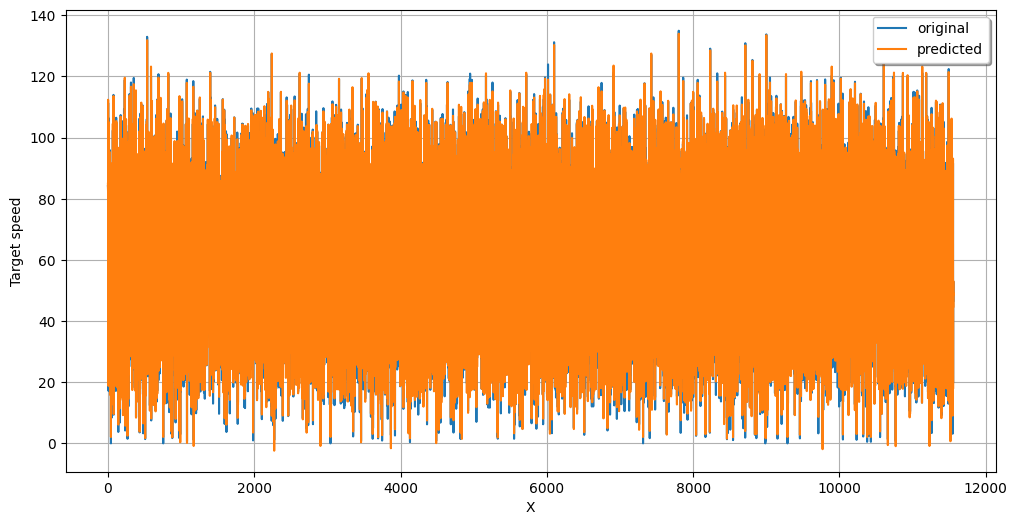

In [240]:
x_ax=range(len(y_test))
plt.figure(figsize=(12,6))
plt.plot(x_ax,y_test,label="original")
plt.plot(x_ax,y_pred,label="predicted")
plt.xlabel('X')
plt.ylabel('Target speed')
plt.legend(loc='best',fancybox=True,shadow=True)
plt.grid(True)
plt.show()

In [241]:
y_pred=np.array(y_pred)
y_test=np.array(y_test)
for x in range(len(y_pred)):
    print(str(y_pred[x])+"--------"+str(y_test[x]))

84.91408149320996--------84.1
83.30015221846166--------83.75
81.87299248517226--------81.73
112.3831450208921--------111.33
84.79082393690001--------83.0
89.77508648996698--------89.17
77.42216135581614--------77.46
18.779711469357647--------17.67
86.45679619907447--------90.24
19.242241974496523--------17.12
82.78004605940464--------80.89
68.61131618292069--------68.05
79.95712700898605--------80.78
90.76708140466306--------90.74
104.94919417794006--------106.24
84.16669002130006--------84.66
35.38974963240746--------37.58
88.64835620138489--------94.73
65.60120009127742--------64.45
41.397605406775035--------40.76
86.53401550528662--------86.08
95.38927750310299--------96.02
70.27337513994577--------68.27
39.23139428095293--------36.11
25.942625786555144--------26.89
21.032704482405666--------18.96
20.21084303527865--------22.19
78.68019996982254--------79.59
84.8479109604581--------86.46
73.40125578917998--------74.82
39.990841425282625--------40.3
15.851505650104379--------16.46
85

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

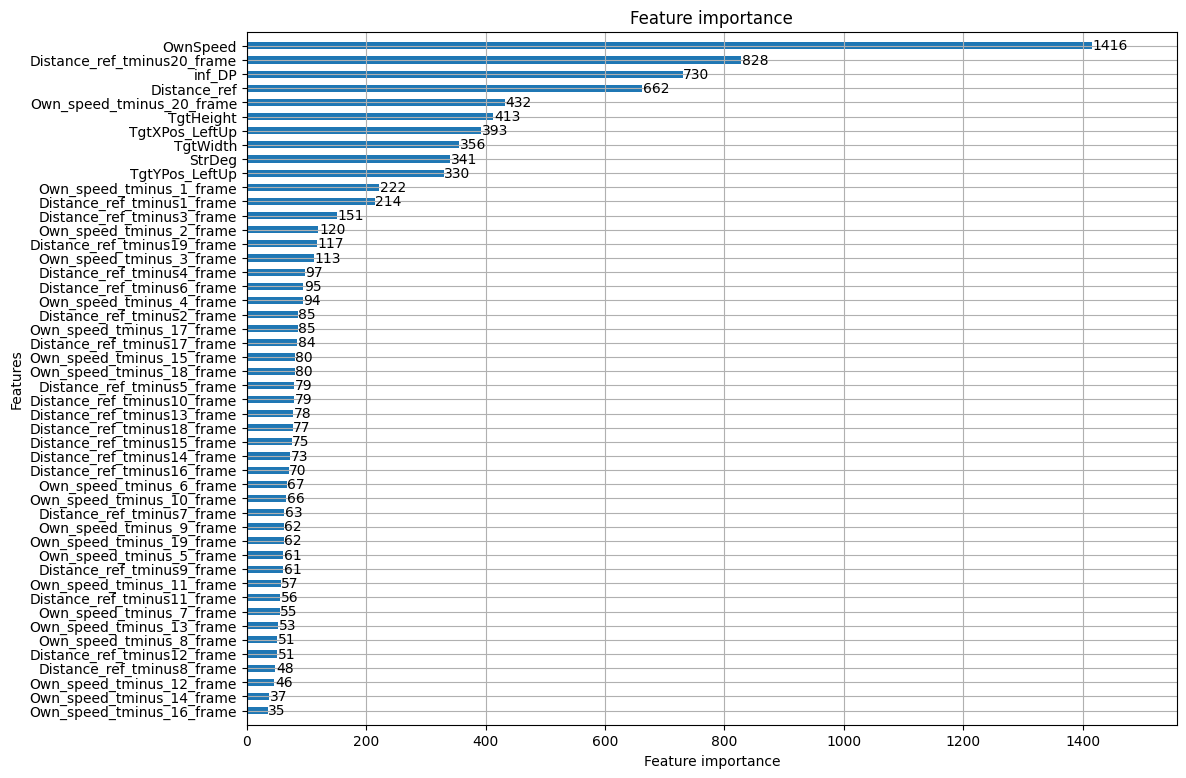

In [242]:
lgb.plot_importance(model,height=.5,figsize=(12,9))

In [266]:
annotation_path = "../complete_test_annotations/"
dir_list = os.listdir(annotation_path)
dir_list.sort()
df1 = pd.DataFrame()
# for inddir in tqdm(dir_list,desc='dirs'):
if(1==1):
    inddir="003.json"
    f = open(annotation_path+inddir)
    data = json.load(f)
    # print(len(data))
    # print(len(raw_file_list))
    local_distance = return_pastframe_combined(data)
    local_distance_decimal=[ round(elem, 2) for elem in local_distance ]
    # print(local_distance)
    df1[inddir[0:3]]=local_distance

In [267]:
df1

,OwnSpeed,StrDeg,inf_DP,TgtXPos_LeftUp,TgtYPos_LeftUp,TgtWidth,TgtHeight,Distance_ref,Own_speed_tminus_20_frame,Distance_ref_tminus20_frame,...,Own_speed_tminus_5_frame,Distance_ref_tminus5_frame,Own_speed_tminus_4_frame,Distance_ref_tminus4_frame,Own_speed_tminus_3_frame,Distance_ref_tminus3_frame,Own_speed_tminus_2_frame,Distance_ref_tminus2_frame,Own_speed_tminus_1_frame,Distance_ref_tminus1_frame
0,58.3,0.6,5.768066,453.0,112.0,67.0,61.0,37.692838,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963
0,58.4,0.6,5.768066,455.0,110.0,65.0,62.0,37.692838,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963
0,58.5,0.6,5.768066,456.0,109.0,64.0,64.0,37.692838,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963
0,58.7,0.8,5.768066,455.0,110.0,65.0,64.0,37.692838,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963
0,58.8,0.8,5.768066,456.0,109.0,64.0,63.0,38.012660,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,58.3,1.0,5.769043,460.0,108.0,70.0,58.0,39.350832,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963
0,58.2,1.0,5.769043,462.0,105.0,68.0,59.0,39.350832,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963
0,58.2,1.0,5.769043,463.0,106.0,67.0,60.0,39.350832,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963
0,58.2,1.0,5.769043,464.0,108.0,66.0,58.0,39.350832,58.3,36.766046,...,57.9,37.378963,58.0,37.378963,58.0,37.378963,58.1,37.378963,58.2,37.378963


In [268]:
y_test_pred=model.predict(df1)

In [269]:
y_test_pred

array([60.09008664, 59.8560224 , 59.84163127, 59.78694067, 59.8013318 ,
       62.78024049, 62.78024049, 62.76584936, 62.83328074, 62.71224851,
       62.71224851, 62.71224851, 62.71125506, 62.71125506, 62.71125506,
       62.71125506, 62.71125506, 62.71125506, 62.76693911, 63.08452849,
       63.08452849, 63.06857873, 63.06857873, 63.06857873, 63.06857873,
       63.29525617, 63.55077755, 63.54577854, 63.4353789 , 63.79275664,
       63.56878246, 63.84104724, 64.40798815, 63.99105229, 60.39288552,
       60.27078216, 63.32240097, 63.30691181, 60.43670886, 60.07386077,
       60.61589297, 60.117435  , 60.32174662, 59.95494645, 60.18901068,
       59.76847002, 59.44907968, 59.75407889, 59.83771383, 59.83771383,
       59.89127587, 59.83771383, 59.83771383, 59.76847002, 59.82203205,
       60.0239914 , 59.82203205, 59.76847002, 59.90803242, 60.05825186,
       60.28130585, 60.25297028, 60.48703452, 60.56067466, 60.48703452,
       60.61977045, 60.61977045, 60.63215625, 60.61977045, 60.61